In [10]:
import pandas as pd
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [11]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [12]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [13]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TCNModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=29,
        output_chunk_length=1,
        num_filters=50,
        kernel_size=8,
        num_layers=3,
        dilation_base=4,
        weight_norm=True,
        n_epochs=100,
        batch_size=107,
        dropout=0.10987578257441336,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.004525867812805064, "weight_decay": 0.00015619537785532893}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.034
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    13.572883    3.684139    2.808369  0.728917   
Precipitation_accumulated       0.211855    0.460277    0.413706  0.663905   
Humidity                      158.528978   12.590829    9.115995  0.495175   
Wind_Speed_kmh                  0.574041    0.757655    0.598736 -0.358189   
Soil_Moisture              213745.875937  462.326590  393.433213  0.655529   
Soil_Temperature                8.910666    2.985074    2.116032  0.877543   
Wind_Dir_Sin                    0.265956    0.515710    0.419134  0.167788   
Wind_Dir_Cos                    0.333862    0.577808    0.430831  0.136920   

                                SMAPE  
Temperature                 15.809403  
Precipitation_accumulated   13.069086  
Humidity                    19.862931  
Wind_Speed_kmh              65.077577  
Soil_Mo

Metric val_loss improved. New best score: 9.349
Metric val_loss improved by 0.668 >= min_delta = 0.001. New best score: 8.681
Metric val_loss improved by 0.409 >= min_delta = 0.001. New best score: 8.272
Metric val_loss improved by 0.291 >= min_delta = 0.001. New best score: 7.982
Metric val_loss improved by 0.372 >= min_delta = 0.001. New best score: 7.610
Metric val_loss improved by 0.379 >= min_delta = 0.001. New best score: 7.232
Metric val_loss improved by 0.370 >= min_delta = 0.001. New best score: 6.862
Metric val_loss improved by 0.347 >= min_delta = 0.001. New best score: 6.515
Metric val_loss improved by 0.272 >= min_delta = 0.001. New best score: 6.243
Metric val_loss improved by 0.195 >= min_delta = 0.001. New best score: 6.047
Metric val_loss improved by 0.184 >= min_delta = 0.001. New best score: 5.864
Metric val_loss improved by 0.211 >= min_delta = 0.001. New best score: 5.653
Metric val_loss improved by 0.234 >= min_delta = 0.001. New best score: 5.419
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                5.099765e+04   225.826584   192.833068   
Precipitation_accumulated  1.089485e+03    33.007352    27.162566   
Humidity                   1.214845e+05   348.546259   294.455584   
Wind_Speed_kmh             9.215196e+01     9.599581     8.259486   
Soil_Moisture              2.177393e+07  4666.254620  3626.586890   
Soil_Temperature           2.542088e+04   159.439274   134.604555   
Wind_Dir_Sin               1.984567e+03    44.548476    37.881083   
Wind_Dir_Cos               1.268363e+02    11.262163     9.640343   

                                    R2       SMAPE  
Temperature               -1469.100166  153.506785  
Precipitation_accumulated     0.972490    8.014667  
Humidity                   -967.363666  143.987463  
Wind_Speed_kmh             -280.230467  152.955320  
Soil_Moisture          

Metric val_loss improved. New best score: 0.021
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.011
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE            R2  \
Temperature                   6.212345   2.492458   2.090430 -1.168409e-01   
Precipitation_accumulated   288.049760  16.972029  14.495465 -2.446864e+06   
Humidity                     13.003901   3.606092   2.954980  2.449206e-01   
Wind_Speed_kmh                0.017753   0.133242   0.107224          -inf   
Soil_Moisture              2947.754957  54.293231  43.264529 -1.202858e+00   
Soil_Temperature              2.746871   1.657369   1.259413  5.649460e-01   
Wind_Dir_Sin                  0.003682   0.060682   0.052644          -inf   
Wind_Dir_Cos                  0.004335   0.065844   0.055857          -inf   

                                SMAPE  
Temperature                 13.996742  
Precipitation_accumulated    3.097089  
Humidity                     3.322401  
Wind_Speed_kmh             200.000000  
Soil_Mo

Metric val_loss improved. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/py

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    0.426940    0.653406    0.431116     0.242693   
Precipitation_accumulated     73.788580    8.590028    6.980452 -2232.057320   
Humidity                      18.063612    4.250131    2.249013    -0.851235   
Wind_Speed_kmh                 0.014767    0.121519    0.080286         -inf   
Soil_Moisture              94501.215635  307.410500  142.901407    -1.735968   
Soil_Temperature               0.964816    0.982250    0.661410    -3.264865   
Wind_Dir_Sin                   0.003287    0.057332    0.046040         -inf   
Wind_Dir_Cos                   0.001421    0.037702    0.027343         -inf   

                                SMAPE  
Temperature                  4.498264  
Precipitation_accumulated    1.540522  
Humidity                     2.392032  
Wind_Speed_kmh             20

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   0.689521   0.830374   0.637053    0.709674   
Precipitation_accumulated    29.820171   5.460785   4.289842 -103.861843   
Humidity                     13.624095   3.691083   3.115574    0.707845   
Wind_Speed_kmh                0.013470   0.116059   0.082791   -5.477236   
Soil_Moisture              2284.649402  47.798006  35.165577    0.716057   
Soil_Temperature              0.560229   0.748484   0.609425    0.654284   
Wind_Dir_Sin                  0.016878   0.129915   0.074446    0.708198   
Wind_Dir_Cos                  0.028224   0.167999   0.108478    0.680766   

                                SMAPE  
Temperature                  9.144714  
Precipitation_accumulated    0.941258  
Humidity                     3.764445  
Wind_Speed_kmh             190.200919  
Soil_Moisture            

Metric val_loss improved. New best score: 0.026
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    1.286411    1.134200    0.811061    0.862968   
Precipitation_accumulated    231.685199   15.221209   13.223032 -199.123902   
Humidity                      10.497486    3.239982    2.407505    0.908977   
Wind_Speed_kmh                 0.587847    0.766712    0.514442    0.622150   
Soil_Moisture              51611.117546  227.180804  178.623367    0.959618   
Soil_Temperature               2.366593    1.538374    1.215292    0.529822   
Wind_Dir_Sin                   0.401375    0.633542    0.452689    0.159782   
Wind_Dir_Cos                   0.309050    0.555923    0.417914    0.366675   

                                SMAPE  
Temperature                 27.180222  
Precipitation_accumulated    2.917833  
Humidity                     2.675106  
Wind_Speed_kmh              85.677956 

Metric val_loss improved. New best score: 0.016
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.043570   1.429535   1.153918    0.924472   
Precipitation_accumulated    55.725740   7.464968   5.965663 -189.674868   
Humidity                     10.676118   3.267433   2.429184    0.929335   
Wind_Speed_kmh                0.487001   0.697855   0.521995    0.594738   
Soil_Moisture              6600.517141  81.243567  67.176774   -0.116076   
Soil_Temperature              0.939300   0.969175   0.808427    0.915760   
Wind_Dir_Sin                  0.385553   0.620929   0.509090    0.280863   
Wind_Dir_Cos                  0.306116   0.553278   0.451349    0.099355   

                                SMAPE  
Temperature                 12.785498  
Precipitation_accumulated    1.292884  
Humidity                     2.976218  
Wind_Speed_kmh              52.416301  
Soil_Moisture            

In [14]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TCNModel(output_chunk_shift=0, kernel_size=8, num_filters=50, num_layers=3, dilation_base=4, weight_norm=True, dropout=0.10987578257441336, model_name=model_1, input_chunk_length=29, output_chunk_length=1, n_epochs=100, batch_size=107, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f3a740aa330>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.004525867812805064, 'weight_decay': 0.00015619537785532893})

In [15]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


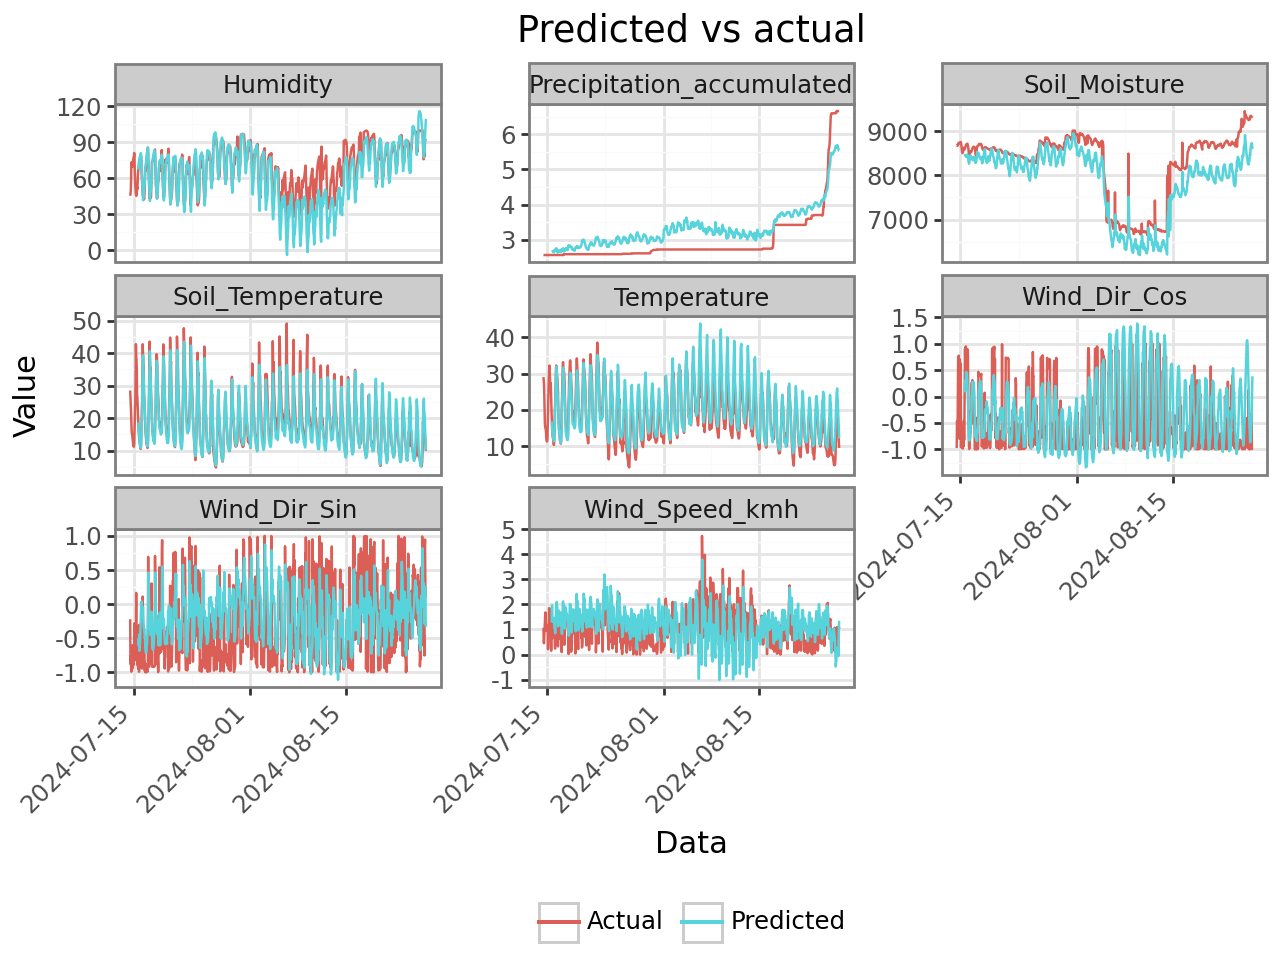

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [16]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

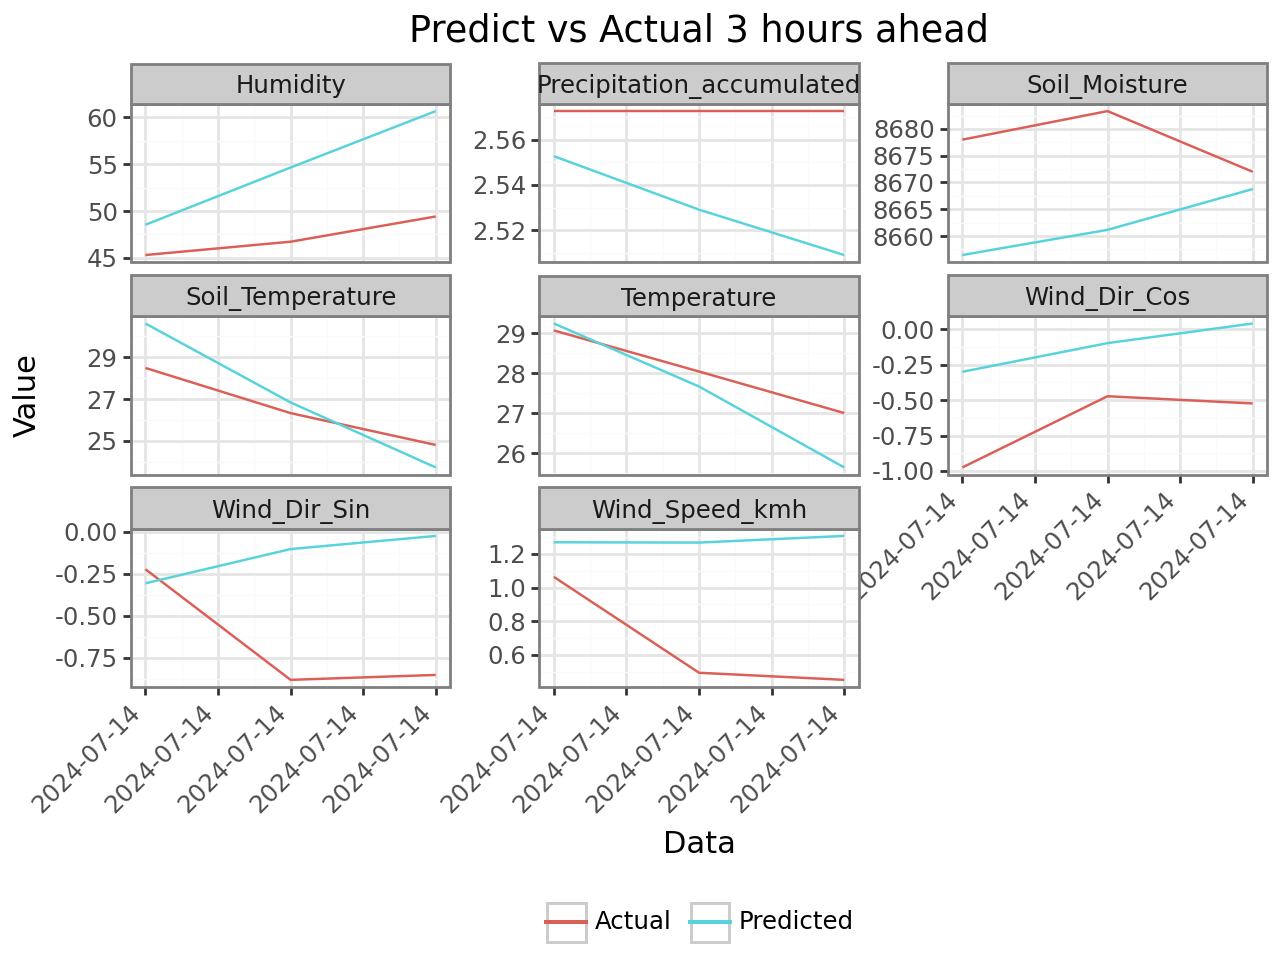

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_3.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(0.6730040950131778), 'RMSE': np.float64(0.8203682679218997), 'MAE': np.float64(0.6359243142609863), 'R2': np.float64(0.051907998285072865), 'SMAPE': np.float64(2.368415721223783)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0021121572082032428), 'RMSE': np.float64(0.04595821154269651), 'MAE': np.float64(0.042352514017269506), 'R2': np.float64(-inf), 'SMAPE': np.float64(1.6624246073763047)}, 'Humidity': {'MSE': np.float64(66.6623582091957), 'RMSE': np.float64(8.164701966954807), 'MAE': np.float64(7.471474384784801), 'R2': np.float64(-21.870277237737387), 'SMAPE': np.float64(14.324263182340365)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.45745029768743284), 'RMSE': np.float64(0.6763507209188387), 'MAE': np.float64(0.6116008016139826), 'R2': np.float64(-4.878713188262446), 'SMAPE': np.float64(67.56137877093619)}, 'Soil_Moisture': {'MSE': np.float64(322.141859975474), 'RMSE': np.float64(17.948310783343207), 'MAE': np.float64(15.649163042391592), 'R2':

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

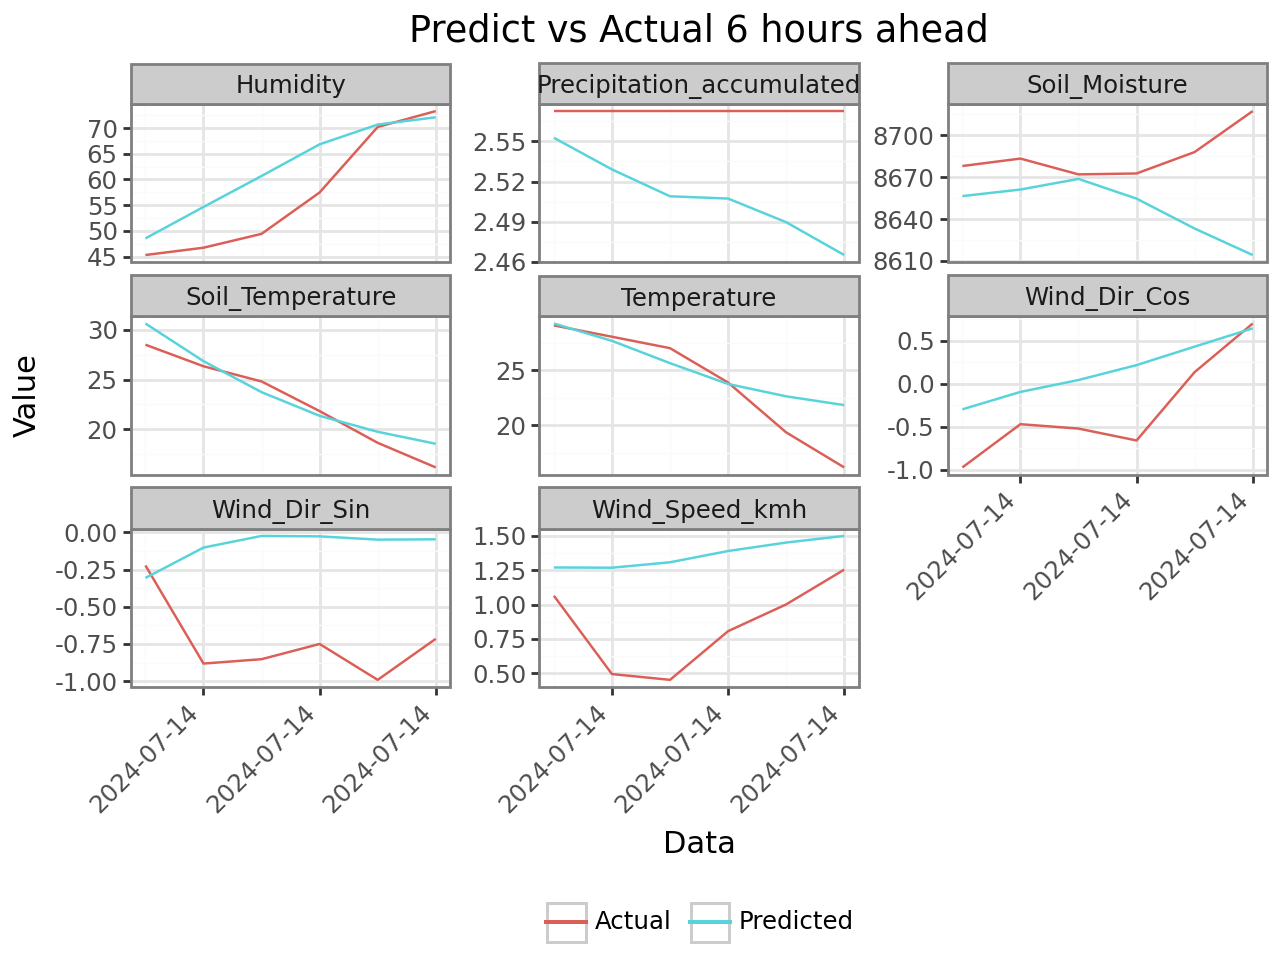

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_6.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(7.444248238530261), 'RMSE': np.float64(2.728414968169296), 'MAE': np.float64(1.8263598117489621), 'R2': np.float64(0.6653716422202087), 'SMAPE': np.float64(8.822970039910134)}, 'Precipitation_accumulated': {'MSE': np.float64(0.004835487600040965), 'RMSE': np.float64(0.06953767036679447), 'MAE': np.float64(0.06377983649216927), 'R2': np.float64(-2.451883503435236e+28), 'SMAPE': np.float64(2.516340538428025)}, 'Humidity': {'MSE': np.float64(48.212089818242255), 'RMSE': np.float64(6.943492623906376), 'MAE': np.float64(5.575078424678104), 'R2': np.float64(0.6090427051958398), 'SMAPE': np.float64(10.059891846374702)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.32913973137390656), 'RMSE': np.float64(0.5737070083011943), 'MAE': np.float64(0.5188352016301244), 'R2': np.float64(-2.811096656512735), 'SMAPE': np.float64(51.71971298475585)}, 'Soil_Moisture': {'MSE': np.float64(2486.0734457300296), 'RMSE': np.float64(49.860539966290276), 'MAE': np.float64(37.137821847

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

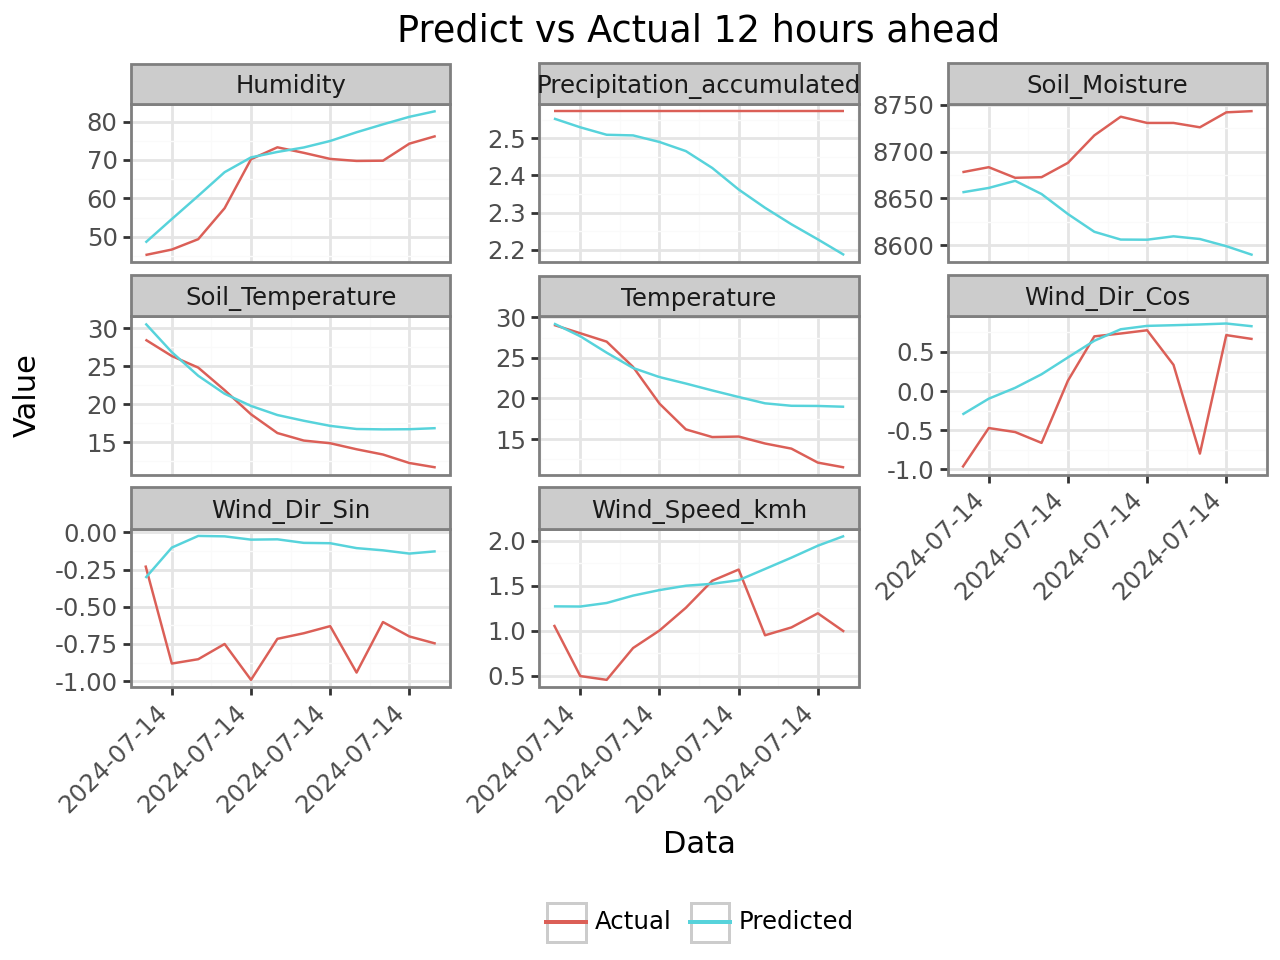

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_12.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(21.549138421214177), 'RMSE': np.float64(4.642104955859375), 'MAE': np.float64(3.8564516805991373), 'R2': np.float64(0.4353432966805526), 'SMAPE': np.float64(22.280576581698583)}, 'Precipitation_accumulated': {'MSE': np.float64(0.04369799629945347), 'RMSE': np.float64(0.2090406570489422), 'MAE': np.float64(0.17002377961627968), 'R2': np.float64(-2.2157516495109256e+29), 'SMAPE': np.float64(6.960011890879632)}, 'Humidity': {'MSE': np.float64(45.70828280566294), 'RMSE': np.float64(6.760790102174667), 'MAE': np.float64(5.822560698394867), 'R2': np.float64(0.6209192636993339), 'SMAPE': np.float64(9.054734026511746)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.4031545627728043), 'RMSE': np.float64(0.6349445351940627), 'MAE': np.float64(0.5497699758961441), 'R2': np.float64(-2.327645995213107), 'SMAPE': np.float64(45.703733064900085)}, 'Soil_Moisture': {'MSE': np.float64(10077.702108083558), 'RMSE': np.float64(100.38775875615292), 'MAE': np.float64(84.7405739966

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

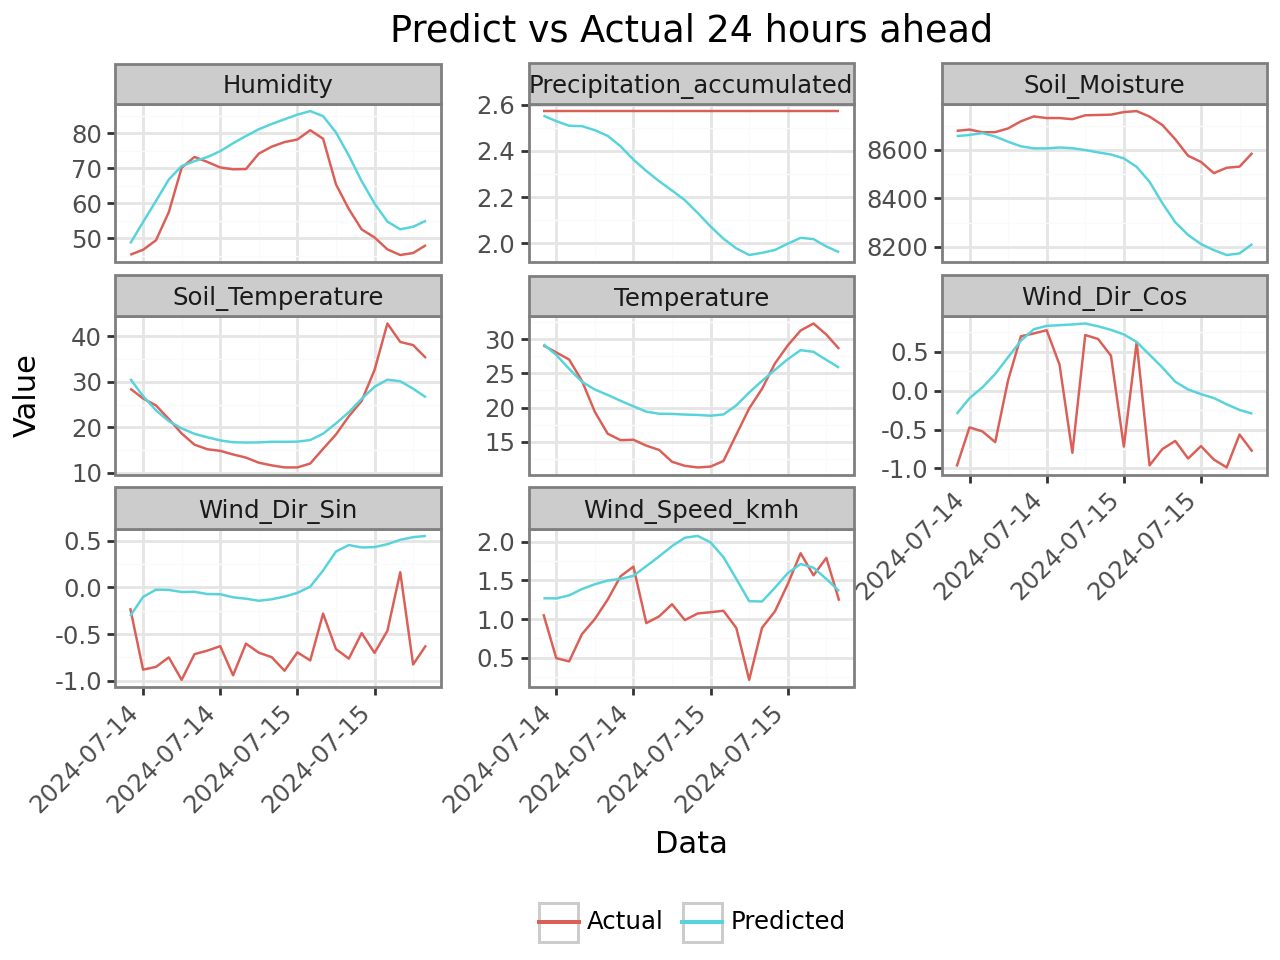

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_24.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(20.604918124747652), 'RMSE': np.float64(4.539264051005146), 'MAE': np.float64(3.8432870245257504), 'R2': np.float64(0.6142274996558025), 'SMAPE': np.float64(21.126653194918358)}, 'Precipitation_accumulated': {'MSE': np.float64(0.18415316847348073), 'RMSE': np.float64(0.42913071257308155), 'MAE': np.float64(0.36875458409379697), 'R2': np.float64(-inf), 'SMAPE': np.float64(15.89033151242063)}, 'Humidity': {'MSE': np.float64(69.86528931912615), 'RMSE': np.float64(8.35854588544719), 'MAE': np.float64(7.457276030630875), 'R2': np.float64(0.5671682379319716), 'SMAPE': np.float64(11.823046775305171)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.3719938724531464), 'RMSE': np.float64(0.6099130040039697), 'MAE': np.float64(0.5113745224936862), 'R2': np.float64(-1.3633535948875464), 'SMAPE': np.float64(42.41559557249546)}, 'Soil_Moisture': {'MSE': np.float64(52008.651220106054), 'RMSE': np.float64(228.05405328585164), 'MAE': np.float64(191.9389853157643), 'R2': np.fl

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

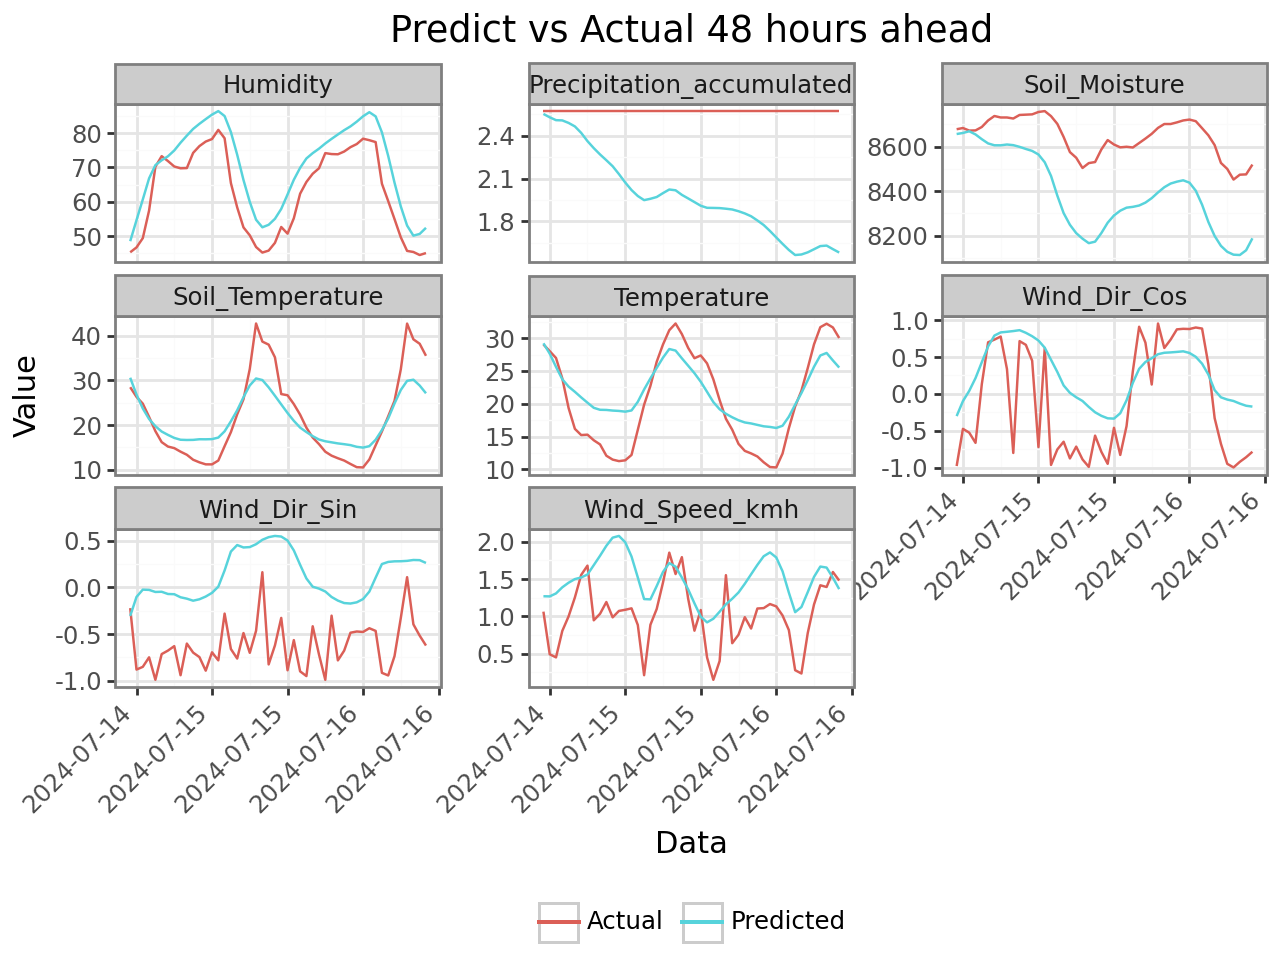

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_48.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(17.77258395786887), 'RMSE': np.float64(4.2157542572911995), 'MAE': np.float64(3.6577350165638163), 'R2': np.float64(0.6768656162806409), 'SMAPE': np.float64(20.00343391188505)}, 'Precipitation_accumulated': {'MSE': np.float64(0.44405488714274854), 'RMSE': np.float64(0.666374434640727), 'MAE': np.float64(0.5985252915557667), 'R2': np.float64(-2.2516257768831354e+30), 'SMAPE': np.float64(27.247066064073973)}, 'Humidity': {'MSE': np.float64(67.34488304670059), 'RMSE': np.float64(8.206392815768728), 'MAE': np.float64(7.502171134776643), 'R2': np.float64(0.5585768630857846), 'SMAPE': np.float64(11.763449136649479)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.33842941074583205), 'RMSE': np.float64(0.5817468613974914), 'MAE': np.float64(0.5081240012586435), 'R2': np.float64(-0.9838213127382982), 'SMAPE': np.float64(46.986779337130876)}, 'Soil_Moisture': {'MSE': np.float64(76975.82826273474), 'RMSE': np.float64(277.44518064427564), 'MAE': np.float64(254.133614413

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

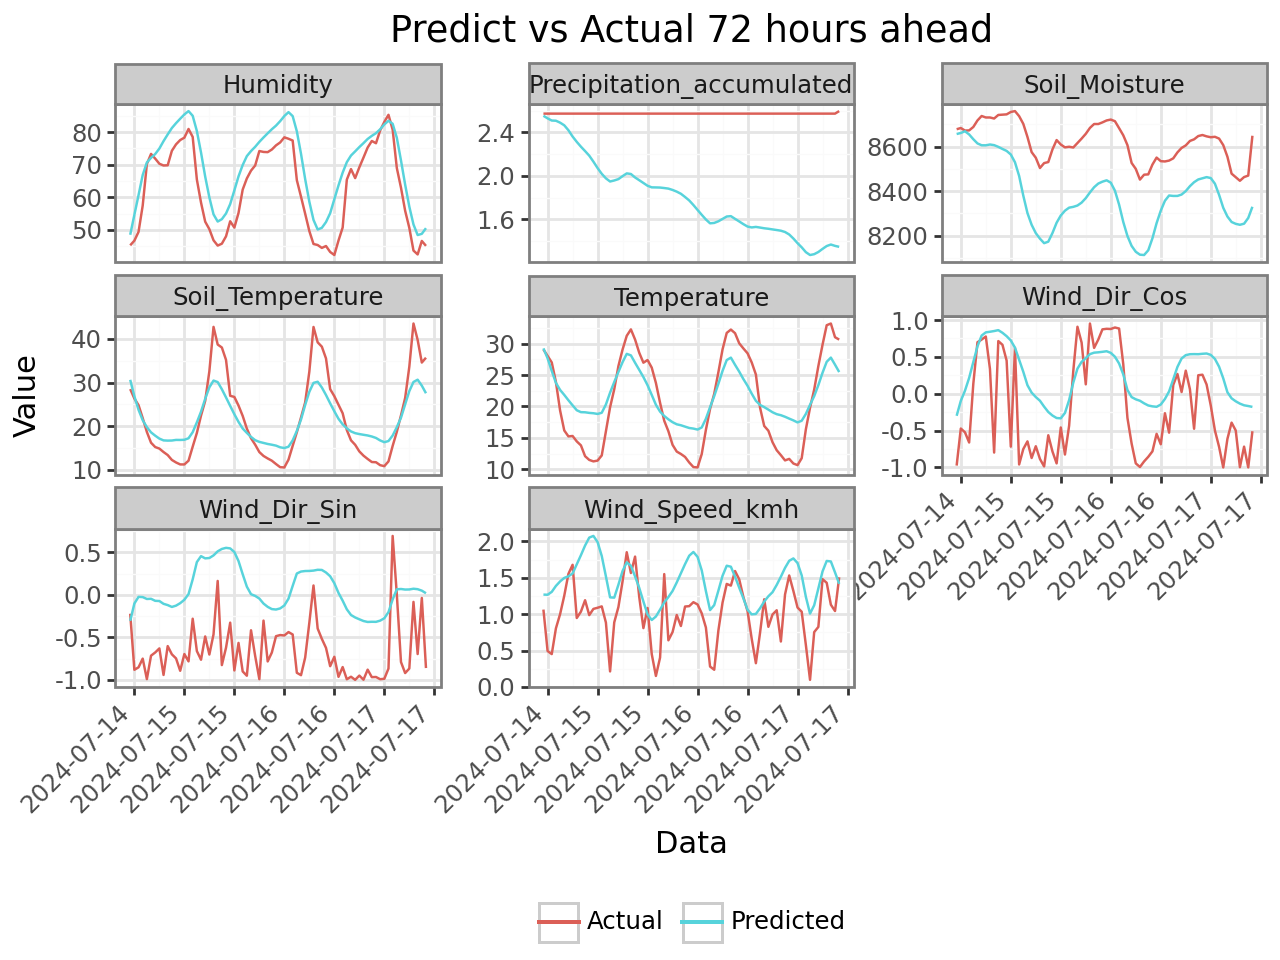

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_72.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(19.795710602090555), 'RMSE': np.float64(4.449237080903933), 'MAE': np.float64(3.938578210288551), 'R2': np.float64(0.6550975313617498), 'SMAPE': np.float64(21.193070348979454)}, 'Precipitation_accumulated': {'MSE': np.float64(0.7382136938243404), 'RMSE': np.float64(0.8591936299952069), 'MAE': np.float64(0.7816276785016332), 'R2': np.float64(-99424.64790924966), 'SMAPE': np.float64(37.346038828384444)}, 'Humidity': {'MSE': np.float64(67.01106587062345), 'RMSE': np.float64(8.186028699596859), 'MAE': np.float64(7.176482991726285), 'R2': np.float64(0.6107158408788542), 'SMAPE': np.float64(11.56311085043737)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.29922819930063027), 'RMSE': np.float64(0.5470175493534282), 'MAE': np.float64(0.4721549710867346), 'R2': np.float64(-0.896809132171613), 'SMAPE': np.float64(44.557604630737224)}, 'Soil_Moisture': {'MSE': np.float64(67083.69560223307), 'RMSE': np.float64(259.00520381303744), 'MAE': np.float64(240.70112625670845),

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

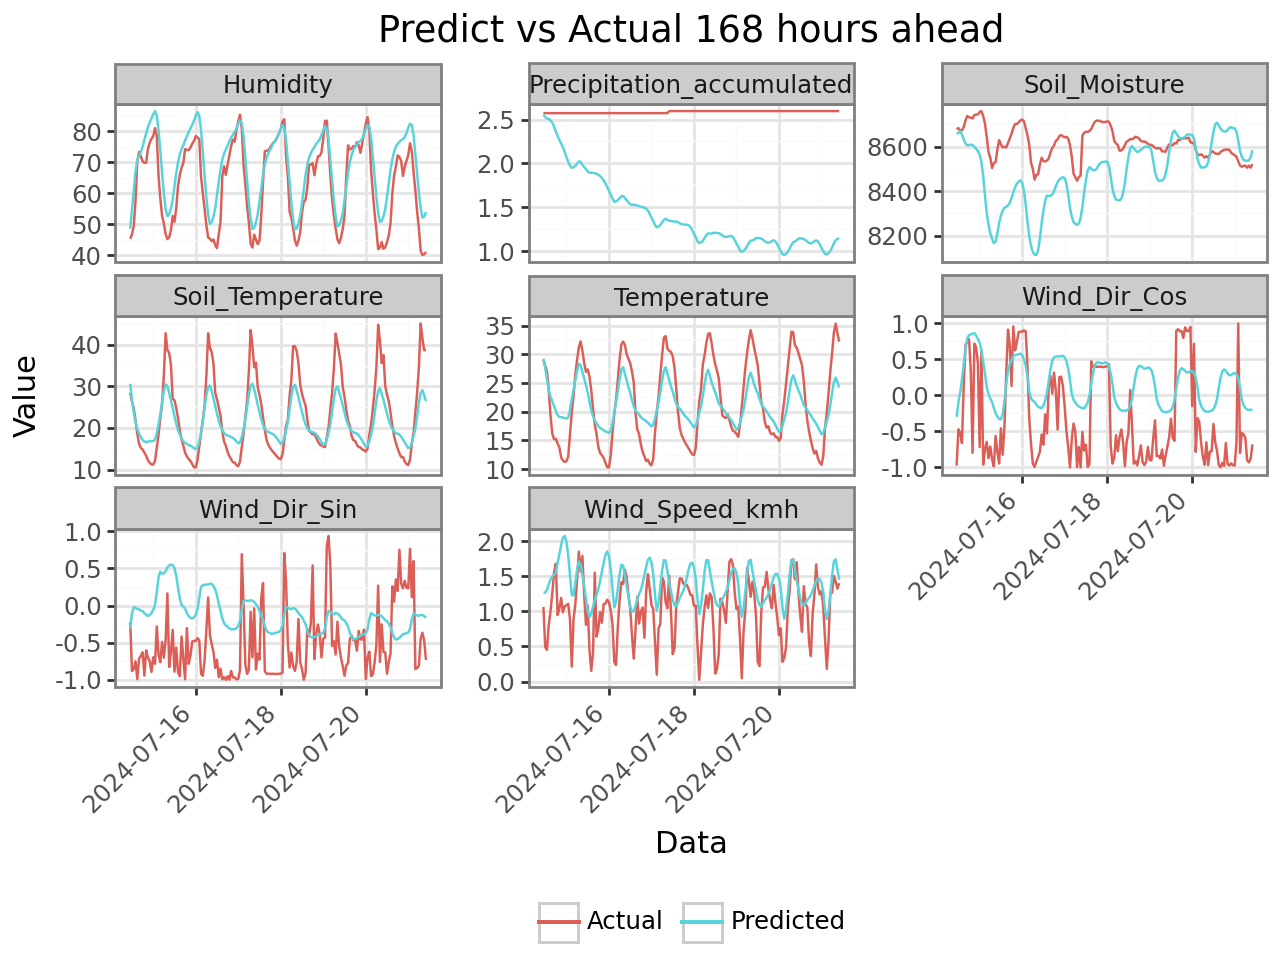

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_168.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(21.218394749014017), 'RMSE': np.float64(4.606342882267235), 'MAE': np.float64(4.024266591721845), 'R2': np.float64(0.6118339237764507), 'SMAPE': np.float64(19.624813741892023)}, 'Precipitation_accumulated': {'MSE': np.float64(1.5446692780428837), 'RMSE': np.float64(1.2428472464638942), 'MAE': np.float64(1.1710235835676126), 'R2': np.float64(-11676.06446886191), 'SMAPE': np.float64(60.95059617960527)}, 'Humidity': {'MSE': np.float64(59.73836406618925), 'RMSE': np.float64(7.729059714233631), 'MAE': np.float64(6.517774828460112), 'R2': np.float64(0.6647318132183713), 'SMAPE': np.float64(10.770494222227004)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.23755715630655352), 'RMSE': np.float64(0.48739835484596533), 'MAE': np.float64(0.4048133763315545), 'R2': np.float64(-0.36821221379758473), 'SMAPE': np.float64(41.02221203234949)}, 'Soil_Moisture': {'MSE': np.float64(37305.2974500548), 'RMSE': np.float64(193.14579324969725), 'MAE': np.float64(158.41217688078655)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

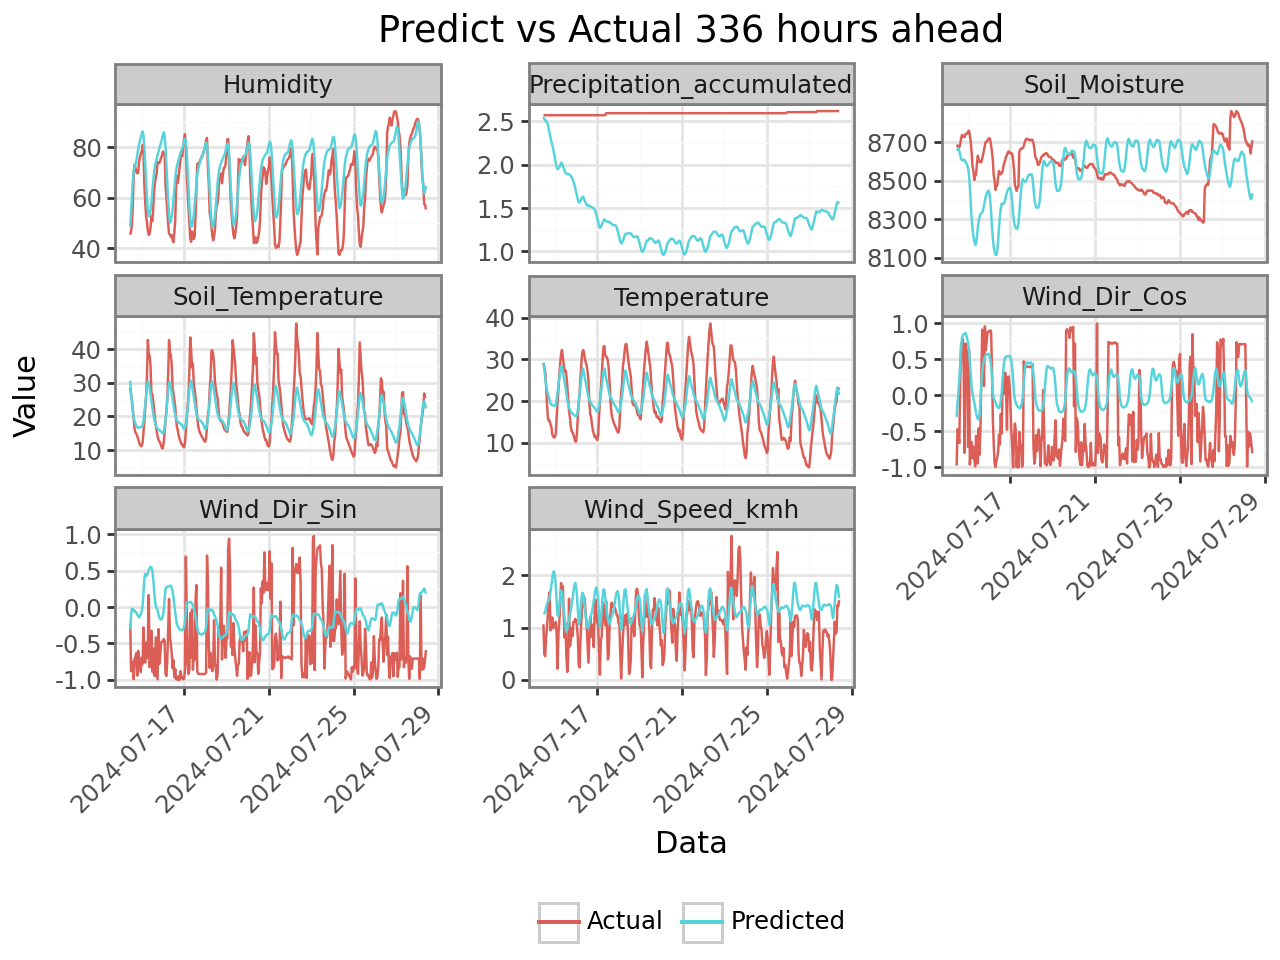

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_336.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(26.673859648557244), 'RMSE': np.float64(5.164674205461294), 'MAE': np.float64(4.4064322049891), 'R2': np.float64(0.5839148408080198), 'SMAPE': np.float64(24.952053252502125)}, 'Precipitation_accumulated': {'MSE': np.float64(1.661326673705696), 'RMSE': np.float64(1.2889246190936443), 'MAE': np.float64(1.2495388774287361), 'R2': np.float64(-9627.349042202175), 'SMAPE': np.float64(64.88215245649778)}, 'Humidity': {'MSE': np.float64(86.67361178550456), 'RMSE': np.float64(9.309866367757625), 'MAE': np.float64(7.715543343569982), 'R2': np.float64(0.587486857595363), 'SMAPE': np.float64(12.447434002045672)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.3295930151274851), 'RMSE': np.float64(0.5741019205049614), 'MAE': np.float64(0.47180250375290117), 'R2': np.float64(-0.30330131959780027), 'SMAPE': np.float64(47.69898892464879)}, 'Soil_Moisture': {'MSE': np.float64(44609.80153153065), 'RMSE': np.float64(211.21032534308225), 'MAE': np.float64(183.1619718217237), 'R2

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

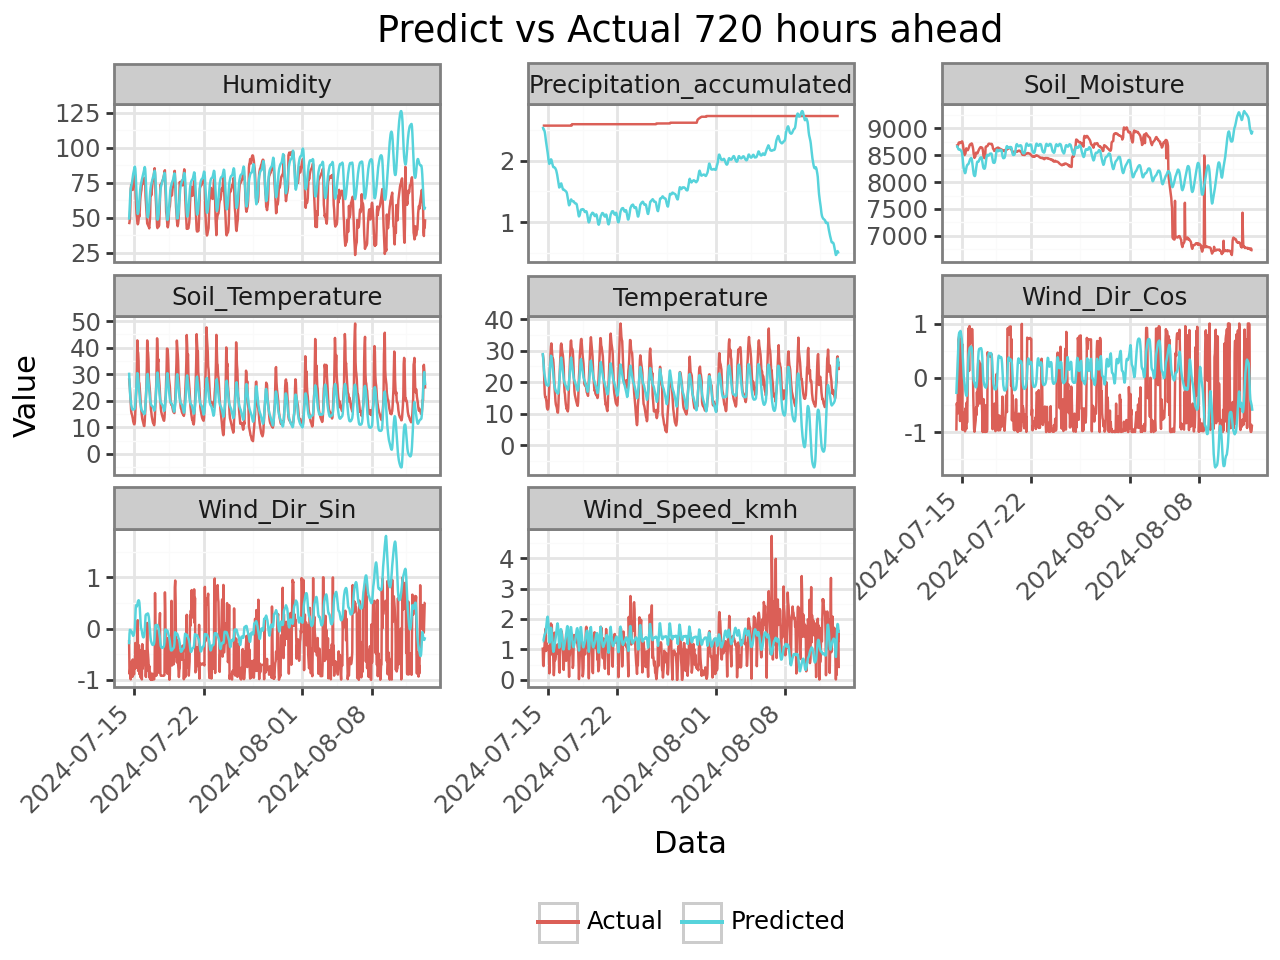

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_720.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(44.350345980622414), 'RMSE': np.float64(6.659605542419341), 'MAE': np.float64(5.078439298869628), 'R2': np.float64(0.12069603221795477), 'SMAPE': np.float64(33.32285659635738)}, 'Precipitation_accumulated': {'MSE': np.float64(1.242572128359159), 'RMSE': np.float64(1.114707194001707), 'MAE': np.float64(1.0040433510464475), 'R2': np.float64(-280.10421629716853), 'SMAPE': np.float64(50.168700283824606)}, 'Humidity': {'MSE': np.float64(460.6235297886792), 'RMSE': np.float64(21.46214178008987), 'MAE': np.float64(16.127842877047655), 'R2': np.float64(-0.7195977384648857), 'SMAPE': np.float64(24.29044989602088)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5606558509608959), 'RMSE': np.float64(0.7487695579822246), 'MAE': np.float64(0.5934258718765693), 'R2': np.float64(-0.25808433442411016), 'SMAPE': np.float64(54.5305690208014)}, 'Soil_Moisture': {'MSE': np.float64(844922.9031217968), 'RMSE': np.float64(919.1968794125646), 'MAE': np.float64(642.1579379488314), '

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

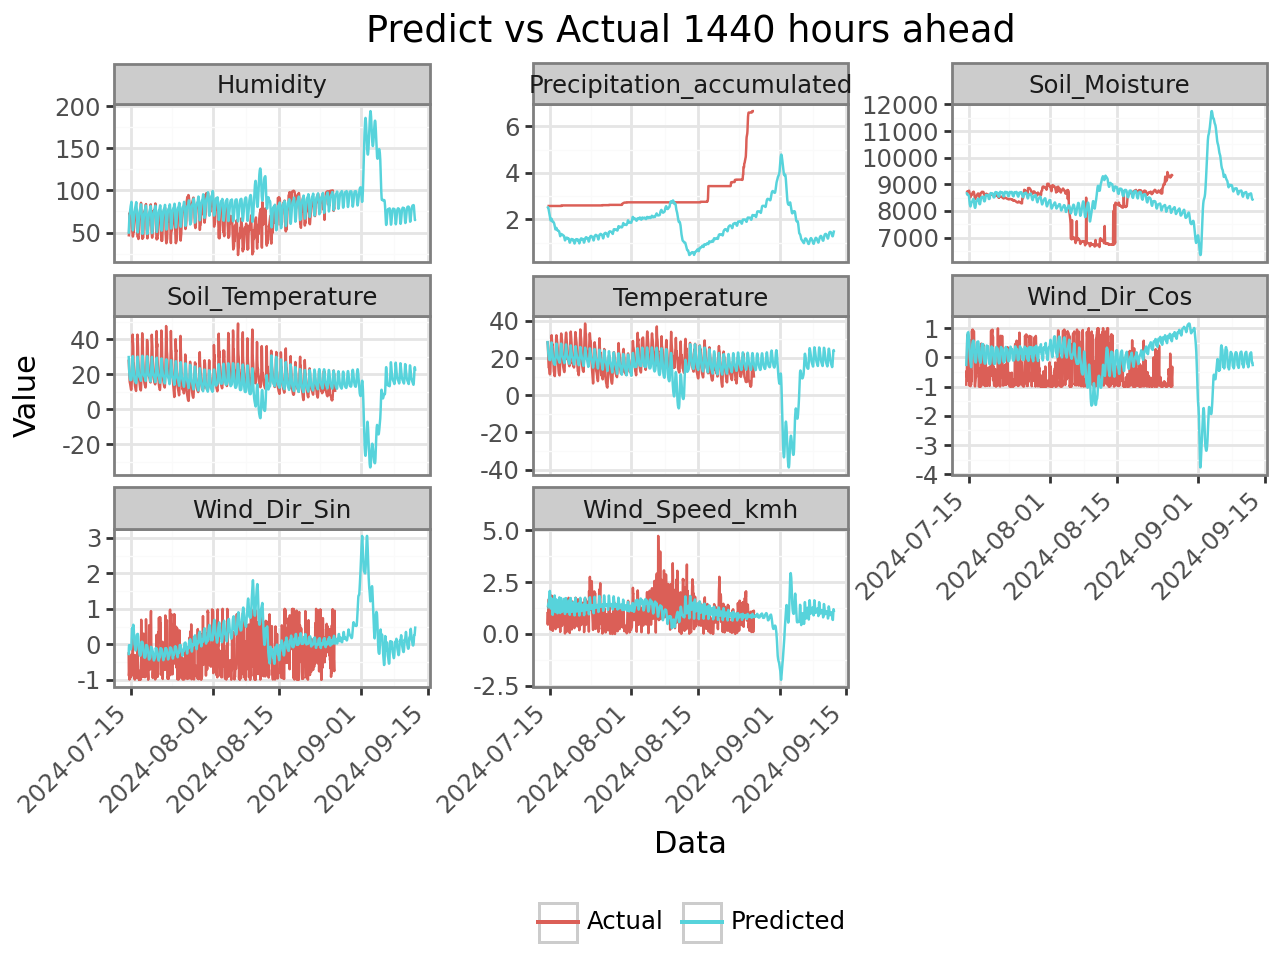

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN/predict_1440.png


{'Temperature': {'MSE': np.float64(35.84156933551914), 'RMSE': np.float64(5.986782886953488), 'MAE': np.float64(4.516399689116746), 'R2': np.float64(0.2874429191029533), 'SMAPE': np.float64(30.575626298686544)}, 'Precipitation_accumulated': {'MSE': np.float64(2.720447313060819), 'RMSE': np.float64(1.6493778563630648), 'MAE': np.float64(1.41023097550033), 'R2': np.float64(-3.4054022332860354), 'SMAPE': np.float64(63.49168844450665)}, 'Humidity': {'MSE': np.float64(340.65208123173795), 'RMSE': np.float64(18.45676247969123), 'MAE': np.float64(13.278742605265132), 'R2': np.float64(-0.09633818344292933), 'SMAPE': np.float64(19.51522028289855)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.46746726803538896), 'RMSE': np.float64(0.683715780156776), 'MAE': np.float64(0.536564142580698), 'R2': np.float64(-0.1229361384909613), 'SMAPE': np.float64(53.874276521773496)}, 'Soil_Moisture': {'MSE': np.float64(801120.9343562708), 'RMSE': np.float64(895.0535930078549), 'MAE': np.float64(629.8221402952727), 'R

In [8]:
m = "TCN"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )

    metrics={}

    pred_t = best_scaler.inverse_transform(pred)
    pred_df = pred_t.to_dataframe()
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"time": "Timestamp"})
    plot_columns = ['Timestamp'] + target_columns
    pred_melted = pred_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    pred_melted['type'] = 'Predicted'

    # Get validation data for comparison
    val_t = best_scaler.inverse_transform(best_val_scaled[:i])
    val_df = val_t.to_dataframe()
    val_df = val_df.reset_index()
    val_df = val_df.rename(columns={"time": "Timestamp"})
    val_melted = val_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    val_melted['type'] = 'Actual'

    # Combine predicted and validation data
    combined_df = pd.concat([pred_melted, val_melted])

    plot = (
        ggplot(combined_df, aes(x='Timestamp', y='value', color='type'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y')
        + labs(
            title=f'Predict vs Actual {i} hours ahead',
            x='Data',
            y='Value',
            color='Data type'
        )
        + theme_bw()
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position='bottom',
            legend_title=element_blank(),

        )
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [9]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)